# Comparing runs using previously calculated `MAF` metrics

## Introduction

This notebook demonstrates some ways to examine, analyze, and compare metrics computed by `MAF` and saved to disk.

It assums the `Computing Metrics in Bulk` notebook has been run, and that the `data_dir` variable will be set to the same directory it was for that notebook.

## Notebook preparation

The following is a development style aid; only uncomment if developing the notebook:

In [1]:
# %load_ext lab_black
# %load_ext pycodestyle_magic
# %flake8_on --ignore E501,W505

Import modules used by this notebook:

In [2]:
import rubin_sim
from rubin_sim import maf

## Set the storage directory for this notebook

Set the directory in which to look for metrics already computed.

In [3]:
from os import path
from os import getcwd

data_dir = path.join(getcwd(), "bulk_metric_data")

# Building a list of data directories and run names

The first thing you need to do is build a list of run names you want to look at, if you don't know them a priori.

You will always need a list of directories in which to look for data, so let's look through our directories for MAF metric output, and extract run names from it.

In [4]:
import pandas as pd
import os


def find_data(data_dirs):
    # Support getting either just one or an iterable
    # of directories
    if isinstance(data_dirs, str):
        data_dirs = [data_dirs]

    all_run_list = []
    for data_dir in data_dirs:
        for dirpath, dirnames, filenames in os.walk(data_dir):
            if "resultsDb_sqlite.db" in filenames:
                results_db = maf.ResultsDb(outDir=dirpath)
                these_runs = pd.read_sql(
                    "SELECT DISTINCT simDataName FROM metrics",
                    results_db.session.connection(),
                )
                these_runs["outDir"] = dirpath
                all_run_list.append(these_runs)

    all_runs = pd.concat(all_run_list)
    return all_runs


maf_data = find_data(data_dir)
maf_data

,simDataName,outDir
0,baseline_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
0,baseline_retrofoot_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
0,retro_baseline_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
0,rolling_ns2_rw0.5_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
0,rolling_ns3_rw0.5_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
0,rolling_ns2_rw0.9_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
0,rolling_ns3_rw0.9_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...


If you want to use a subset of runs, you can limit the data found to just those:

In [5]:
use_all_runs = True
if not use_all_runs:
    wanted_runs = [
        "baseline_v3.0_10yrs",
        "retro_baseline_v2.0_10yrs",
        "rolling_ns2_rw0.9_v2.0_10yrs",
    ]
    maf_data = maf_data.set_index("simDataName").loc[wanted_runs].reset_index()

# Seeing what data you've got

Let's take a look at what we have. This requires iterating over the data from each results database.

## Finding the metrics that have been calculated

Iterate through each row of the `maf_data` `DataFrame`, and extract the run name and its directory from each row.

Then, create an interface to the results database in each director by instantiting a `maf.ResultsDb` object, query it for the metrics it has for the relevant run, and use it to retrieve the metadata of each metric present for that run.

Store the results for all found metrics in a `pandas.DataFrame` that can be examined visually or queried later.

In [6]:
metric_df_list = []

# Iterate through each row of the maf_data
for _, run_result_meta in maf_data.iterrows():
    # Extract the run and dirctory from each row of the DataFrame
    run_name = run_result_meta.simDataName
    out_dir = run_result_meta.outDir

    # Create an interface to the results database
    # in the specified directory
    results_db = maf.ResultsDb(outDir=out_dir)

    # Read the numeric metric ids for metrics on the run we want
    metric_ids = results_db.getMetricIdLike(simDataName=run_name)

    # Read the metric metadata for the run we want from the database.
    # For results databases created by the Compute Metrics in Bulk database,
    # there should only be data for the one run in each database,
    # but this is not guaranteed in general.
    metric_df = pd.DataFrame(
        results_db.getMetricInfo(metricId=metric_ids, withSimName=True)
    )

    # We will be combining all runs into the same
    # dataframe, so all columns to let us distinguish
    # what came from where.
    metric_df["outDir"] = out_dir
    metric_df_list.append(metric_df)

metric_df = pd.concat(metric_df_list)
metric_df

,metricId,metricName,baseMetricNames,slicerName,sqlConstraint,metricMetadata,metricDataFile,simDataName,outDir
0,1,OpenShutterFraction,OpenShutterFraction,UniSlicer,,,baseline_v2_0_10yrs_OpenShutterFraction_UNIS.npz,baseline_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
1,2,Count airmass,Count airmass,OneDSlicer,,,baseline_v2_0_10yrs_Count_airmass_ONED.npz,baseline_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
2,3,CoaddM5,CoaddM5,HealpixSlicer,filter = 'i',i,baseline_v2_0_10yrs_CoaddM5_i_HEAL.npz,baseline_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
3,4,CoaddM5,CoaddM5,HealpixSlicer,filter = 'g',g,baseline_v2_0_10yrs_CoaddM5_g_HEAL.npz,baseline_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
0,1,OpenShutterFraction,OpenShutterFraction,UniSlicer,,,baseline_retrofoot_v2_0_10yrs_OpenShutterFract...,baseline_retrofoot_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
1,2,Count airmass,Count airmass,OneDSlicer,,,baseline_retrofoot_v2_0_10yrs_Count_airmass_ON...,baseline_retrofoot_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
2,3,CoaddM5,CoaddM5,HealpixSlicer,filter = 'i',i,baseline_retrofoot_v2_0_10yrs_CoaddM5_i_HEAL.npz,baseline_retrofoot_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
3,4,CoaddM5,CoaddM5,HealpixSlicer,filter = 'g',g,baseline_retrofoot_v2_0_10yrs_CoaddM5_g_HEAL.npz,baseline_retrofoot_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
0,1,OpenShutterFraction,OpenShutterFraction,UniSlicer,,,retro_baseline_v2_0_10yrs_OpenShutterFraction_...,retro_baseline_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...
1,2,Count airmass,Count airmass,OneDSlicer,,,retro_baseline_v2_0_10yrs_Count_airmass_ONED.npz,retro_baseline_v2.0_10yrs,/data/des91.b/data/neilsen/LSST/devel/rubin_si...


# Examining summary statistics for one run

The results database also contains all of the summary statistics. 

If you have a run for which you want statistics:

In [7]:
run_name = "baseline_v2.0_10yrs"

begin by querying the `maf_data` `DataFrame` for the directory:

In [8]:
out_dir = maf_data.set_index("simDataName").loc[run_name, "outDir"]
out_dir

'/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example'

Now, create our instance of `ResultsDB` to serve as an interface:

In [9]:
results_db = maf.ResultsDb(outDir=out_dir)

Take a look at the summary statistics recorded in this specific results database, turning it into a `pandas.DataFrame` for easier viewing:

In [10]:
sum_stats = pd.DataFrame(results_db.getSummaryStats(withSimName=True))
sum_stats.head()

,metricId,summaryName,metricName,slicerName,metricMetadata,summaryMetric,summaryValue,simDataName
0,1,OpenShutterFraction,OpenShutterFraction,UniSlicer,,Identity,0.722458,baseline_v2.0_10yrs
1,2,Mean Count airmass OneDSlicer,Count airmass,OneDSlicer,,Mean,69566.000000,baseline_v2.0_10yrs
2,2,Rms Count airmass OneDSlicer,Count airmass,OneDSlicer,,Rms,103403.912924,baseline_v2.0_10yrs
3,2,Median Count airmass OneDSlicer,Count airmass,OneDSlicer,,Median,13391.500000,baseline_v2.0_10yrs
4,2,Max Count airmass OneDSlicer,Count airmass,OneDSlicer,,Max,365361.000000,baseline_v2.0_10yrs


In this example there is only one run in the database, but in general we need to select on the run name to make sure we are getting the stats for just the run we want:

In [11]:
sum_stats = sum_stats.query(f'simDataName == "{run_name}"')
sum_stats

,metricId,summaryName,metricName,slicerName,metricMetadata,summaryMetric,summaryValue,simDataName
0,1,OpenShutterFraction,OpenShutterFraction,UniSlicer,,Identity,0.722458,baseline_v2.0_10yrs
1,2,Mean Count airmass OneDSlicer,Count airmass,OneDSlicer,,Mean,69566.000000,baseline_v2.0_10yrs
2,2,Rms Count airmass OneDSlicer,Count airmass,OneDSlicer,,Rms,103403.912924,baseline_v2.0_10yrs
3,2,Median Count airmass OneDSlicer,Count airmass,OneDSlicer,,Median,13391.500000,baseline_v2.0_10yrs
4,2,Max Count airmass OneDSlicer,Count airmass,OneDSlicer,,Max,365361.000000,baseline_v2.0_10yrs
5,2,Min Count airmass OneDSlicer,Count airmass,OneDSlicer,,Min,831.000000,baseline_v2.0_10yrs
6,2,N(+3Sigma) Count airmass OneDSlicer,Count airmass,OneDSlicer,,N(+3Sigma),0.000000,baseline_v2.0_10yrs
7,2,N(-3Sigma) Count airmass OneDSlicer,Count airmass,OneDSlicer,,N(-3Sigma),0.000000,baseline_v2.0_10yrs
8,2,Count airmass OneDSlicer,Count airmass,OneDSlicer,,Count,30.000000,baseline_v2.0_10yrs
9,2,25th%ile Count airmass OneDSlicer,Count airmass,OneDSlicer,,25th%ile,3339.000000,baseline_v2.0_10yrs


# Looking at a plot you've made already

The names of the files into which plots were saved are recorded in the `ResultsDB`. So, we can use an instance of a `ResultsDB` to see what we made, and then build the full file name and show the plot:

As above, grab a sample `out_dir` from our list of data, and instantiate a `ResultsDB`:

Repeat the procedure followed for the summary statistics example to get an instance of `ResultsDB` to the relevant results database:

In [12]:
run_name = "baseline_v2.0_10yrs"
out_dir = maf_data.set_index("simDataName").loc[run_name, "outDir"]
results_db = maf.ResultsDb(outDir=out_dir)

Query the plot metadata from the results database and convert it to a `pandas.DataFrame` for easy viewing:

In [13]:
import pandas as pd


plot_files = pd.DataFrame(results_db.getPlotFiles(withSimName=True))
plot_files

,metricId,metricName,metricMetadata,plotType,plotFile,thumbFile,simDataName
0,2,Count airmass,,BinnedData,baseline_v2_0_10yrs_Count_airmass_ONED_BinnedD...,thumb.baseline_v2_0_10yrs_Count_airmass_ONED_B...,baseline_v2.0_10yrs
1,3,CoaddM5,i,SkyMap,baseline_v2_0_10yrs_CoaddM5_i_HEAL_SkyMap.pdf,thumb.baseline_v2_0_10yrs_CoaddM5_i_HEAL_SkyMa...,baseline_v2.0_10yrs
2,3,CoaddM5,i,Histogram,baseline_v2_0_10yrs_CoaddM5_i_HEAL_Histogram.pdf,thumb.baseline_v2_0_10yrs_CoaddM5_i_HEAL_Histo...,baseline_v2.0_10yrs
3,4,CoaddM5,g,SkyMap,baseline_v2_0_10yrs_CoaddM5_g_HEAL_SkyMap.pdf,thumb.baseline_v2_0_10yrs_CoaddM5_g_HEAL_SkyMa...,baseline_v2.0_10yrs
4,4,CoaddM5,g,Histogram,baseline_v2_0_10yrs_CoaddM5_g_HEAL_Histogram.pdf,thumb.baseline_v2_0_10yrs_CoaddM5_g_HEAL_Histo...,baseline_v2.0_10yrs


In this case, the run name can be inferred from the file names (in `plotFile` and `thumbFile`), and we can see that there is only one run in the directory. If there is more than one run in the directory, you will need to parse the run name back out of the file name, or query the results db for the metric ids corresponding to the runs we want, and filter the plots for just those metric ids:

In [14]:
run_metric_ids = results_db.getMetricIdLike(simDataName=run_name)
plot_files = plot_files[plot_files.metricId.isin(run_metric_ids)]
plot_files

,metricId,metricName,metricMetadata,plotType,plotFile,thumbFile,simDataName
0,2,Count airmass,,BinnedData,baseline_v2_0_10yrs_Count_airmass_ONED_BinnedD...,thumb.baseline_v2_0_10yrs_Count_airmass_ONED_B...,baseline_v2.0_10yrs
1,3,CoaddM5,i,SkyMap,baseline_v2_0_10yrs_CoaddM5_i_HEAL_SkyMap.pdf,thumb.baseline_v2_0_10yrs_CoaddM5_i_HEAL_SkyMa...,baseline_v2.0_10yrs
2,3,CoaddM5,i,Histogram,baseline_v2_0_10yrs_CoaddM5_i_HEAL_Histogram.pdf,thumb.baseline_v2_0_10yrs_CoaddM5_i_HEAL_Histo...,baseline_v2.0_10yrs
3,4,CoaddM5,g,SkyMap,baseline_v2_0_10yrs_CoaddM5_g_HEAL_SkyMap.pdf,thumb.baseline_v2_0_10yrs_CoaddM5_g_HEAL_SkyMa...,baseline_v2.0_10yrs
4,4,CoaddM5,g,Histogram,baseline_v2_0_10yrs_CoaddM5_g_HEAL_Histogram.pdf,thumb.baseline_v2_0_10yrs_CoaddM5_g_HEAL_Histo...,baseline_v2.0_10yrs


The `thumbFile` column lists the names of the plot files in `png` format.

There are a variety of ways to extract the file name for just one desired plot from the `pandas.DataFrame`.

One way is to set the columns we want to search on as the index, and then just slice the `DataFrame` on those indices:

In [15]:
plot_files.set_index(["plotType", "metricName", "metricMetadata"], inplace=True)
fname = plot_files.loc[("SkyMap", "CoaddM5", "i"), "thumbFile"]
fname

'thumb.baseline_v2_0_10yrs_CoaddM5_i_HEAL_SkyMap.png'

We can then combine the know `out_dir` with the `thumbFile` in the plot files table (which has the name of the `png` file) to get a full path we can use to load and display a plot:

In [16]:
full_fname = os.path.join(out_dir, fname)

Now we can load and display it:

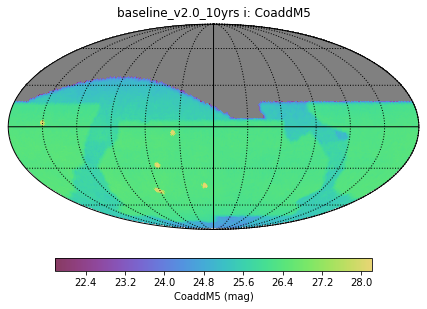

In [17]:
from IPython.display import Image


display(Image(full_fname))

# Making a new plot

To make a new plot that wasn't created in our batch run, we need to load the metric data itself into a new metric bundle.

Again, let's create an instance of `ResultsDB` that has our desired run:

In [18]:
run_name = "baseline_v2.0_10yrs"
out_dir = maf_data.set_index("simDataName").loc[run_name, "outDir"]
results_db = maf.ResultsDb(outDir=out_dir)

Start by asking the results database for the metric id corresponding to the one we want:

In [19]:
metric_name = "CoaddM5"
slicer_name = "HealpixSlicer"
metric_metadata = "i"

metric_ids = results_db.getMetricId(metric_name, slicer_name, metric_metadata, run_name)
metric_ids

[3]

This returned a list, because there could potentially have been more than one match. There's just one here, though, the one we want, so take it:

In [20]:
metric_id = metric_ids[0]

Use this `metric_id` to get metadata on the metric:

In [21]:
metric_info = results_db.getMetricInfo(metric_id)[0]

Extract the name of the data file, and tack on the directory so we have a file with a usable path:

In [22]:
fname = os.path.join(out_dir, metric_info["metricDataFile"])
fname

'/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/baseline_v2_0_10yrs_CoaddM5_i_HEAL.npz'

Create a new, empty bundle into which to load our data:

In [23]:
bundle = maf.createEmptyMetricBundle()

Actually load it:

In [24]:
bundle.read(fname)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Now we can adjust the plot functions and plotting parameters and replot, for example using a [Lambert Azimutha Equal-Area projection](https://en.wikipedia.org/wiki/Lambert_azimuthal_equal-area_projection):

0.0 180.0 -180.0 180.0
/data/des91.b/data/neilsen/anaconda/envs/rubin_sim/lib/python3.9/site-packages/healpy/projector.py:1080: RuntimeWarning: divide by zero encountered in true_divide
  kprime = np.sqrt(2.0 / (1.0 + np.cos(lat) * np.cos(phi)))
/data/des91.b/data/neilsen/anaconda/envs/rubin_sim/lib/python3.9/site-packages/healpy/projector.py:1085: RuntimeWarning: invalid value encountered in multiply
  y = kprime * np.sin(lat)


{'SkyMap': 1}

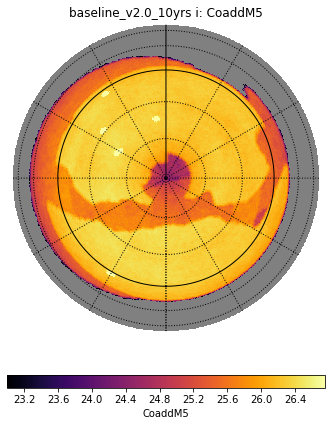

In [25]:
import matplotlib.pyplot as plt
import healpy as hp


plot_dict = {
    "rot": (0, -90, 0),
    "colorMin": 23,
    "colorMax": 26.75,
    "cmap": plt.get_cmap("inferno"),
    "visufunc": hp.azeqview,
    "lamb": True,
    "reso": 17.5,
    "figsize": (6, 6),
}
bundle.setPlotFuncs([maf.HealpixSkyMap()])
bundle.setPlotDict(plot_dict)
bundle.plot()

# Full metric comparison runs from many plots

To compare runs, begin by creating an instance of `maf.RunComparison` that points to all of the relevant results databases:

In [26]:
run_comp = maf.RunComparison(runDirs=maf_data.outDir)

Our instance of `RunComparison` can also be used to build a dictionory describing the various metrics that were run in the runs being compared:

In [27]:
metric_dict = run_comp.buildMetricDict()
metric_dict

{'OpenShutterFraction': {'metricName': 'OpenShutterFraction',
  'metricMetadata': '',
  'slicerName': 'UniSlicer'},
 'Count airmass  OneDSlicer': {'metricName': 'Count airmass',
  'metricMetadata': '',
  'slicerName': 'OneDSlicer'},
 'CoaddM5 i HealpixSlicer': {'metricName': 'CoaddM5',
  'metricMetadata': 'i',
  'slicerName': 'HealpixSlicer'},
 'CoaddM5 g HealpixSlicer': {'metricName': 'CoaddM5',
  'metricMetadata': 'g',
  'slicerName': 'HealpixSlicer'}}

Use your instance of `RunComparison` to read the metric data itself:

In [28]:
metric_name = "Count airmass"
metric_metadata = ""
slicer_name = "OneDSlicer"
bundles, metric_name = run_comp.readMetricData(
    metric_name, metric_metadata, slicer_name
)

`bundles` is now a dictionary whose keys are run names, and whose values are metric bundles of the sort we asked for:

In [29]:
bundles

{'baseline_v2.0_10yrs Count airmass  OneDSlicer': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f19883a6d30>,
 'baseline_retrofoot_v2.0_10yrs Count airmass  OneDSlicer': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f19883b7850>,
 'retro_baseline_v2.0_10yrs Count airmass  OneDSlicer': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f19883b79a0>,
 'rolling_ns2_rw0.5_v2.0_10yrs Count airmass  OneDSlicer': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f19883c5a90>,
 'rolling_ns3_rw0.5_v2.0_10yrs Count airmass  OneDSlicer': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f19883c5310>,
 'rolling_ns2_rw0.9_v2.0_10yrs Count airmass  OneDSlicer': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f19883b78b0>,
 'rolling_ns3_rw0.9_v2.0_10yrs Count airmass  OneDSlicer': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f19883c87f0>}

Now we can use our instance of `RunComparison` to plot the metrics from all of the runs together:

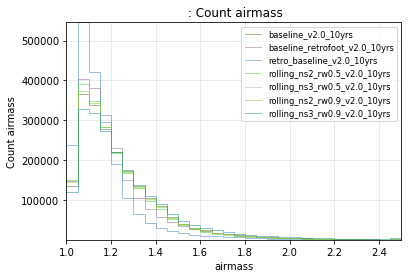

In [30]:
run_comp.plotMetricData(bundles, maf.OneDBinnedData())

We can do more complex replotting as well, including major changes to the plotting parameters. 

Let's look at a different metric, and replot it, but with parameter different from what we did originally:

First we need to actually load the metric data we are interested in:

In [31]:
metric_name = "CoaddM5"
metric_metadata = "i"
slicer_name = "HealpixSlicer"
bundles, metric_name = run_comp.readMetricData(
    metric_name, metric_metadata, slicer_name
)
bundles

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


{'baseline_v2.0_10yrs CoaddM5 i HealpixSlicer': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f1988406ee0>,
 'baseline_retrofoot_v2.0_10yrs CoaddM5 i HealpixSlicer': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f1988353a90>,
 'retro_baseline_v2.0_10yrs CoaddM5 i HealpixSlicer': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f1988310910>,
 'rolling_ns2_rw0.5_v2.0_10yrs CoaddM5 i HealpixSlicer': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f1988312c40>,
 'rolling_ns3_rw0.5_v2.0_10yrs CoaddM5 i HealpixSlicer': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f1988319940>,
 'rolling_ns2_rw0.9_v2.0_10yrs CoaddM5 i HealpixSlicer': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f1988312190>,
 'rolling_ns3_rw0.9_v2.0_10yrs CoaddM5 i HealpixSlicer': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7f1988310610>}

You can do more complicated things with modifying plotting parameters and showing maps in grids:

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


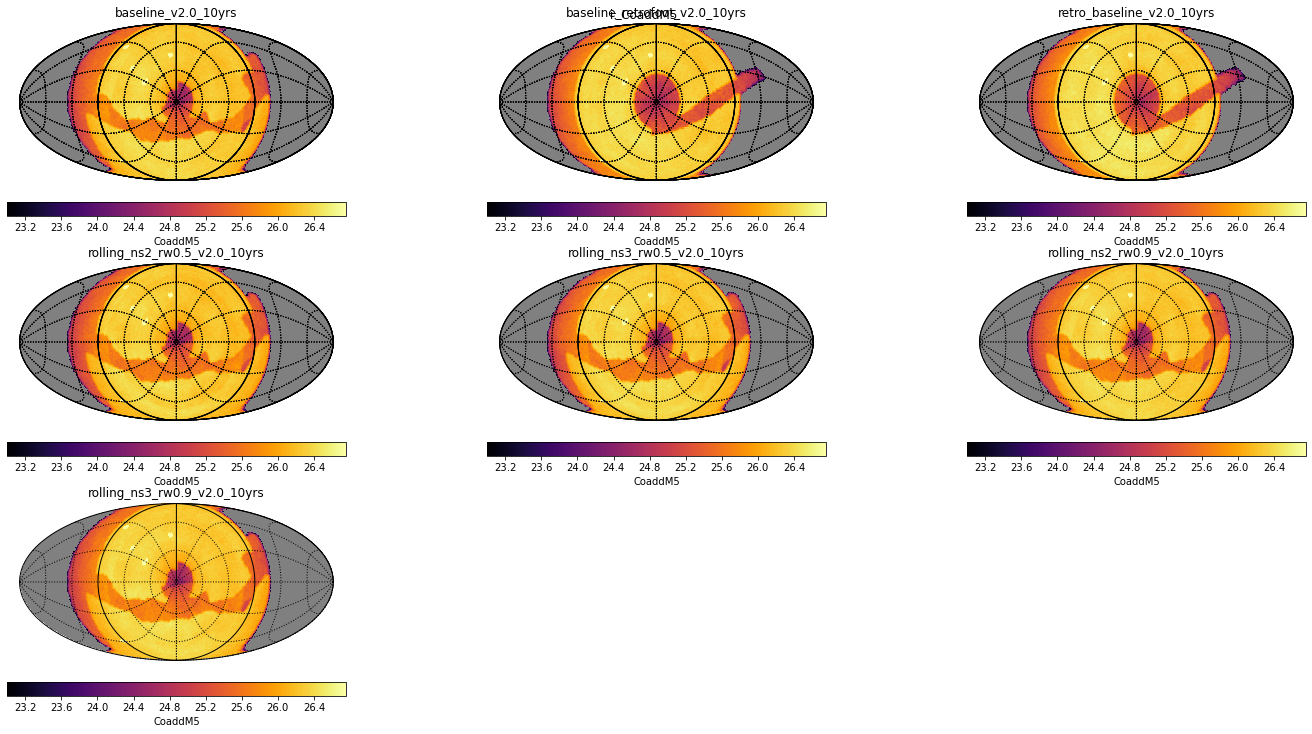

In [32]:
import matplotlib.pyplot as plt


plot_dict = {
    "rot": (0, -90, 0),
    "colorMin": 23,
    "colorMax": 26.75,
    "cmap": plt.get_cmap("inferno"),
    "figsize": (20, 10),
}
run_comp.plotMetricData(bundles, maf.HealpixSkyMap(), userPlotDict=plot_dict)

# Comparing summary metrics from many runs

Load the summary data for all of your runs to be compared:

In [33]:
run_comp.addSummaryStats(metric_dict)

In [34]:
summary_matrix = run_comp.summaryStats
summary_matrix

metric,OpenShutterFraction,Mean Count airmass OneDSlicer,Rms Count airmass OneDSlicer,Median Count airmass OneDSlicer,Max Count airmass OneDSlicer,Min Count airmass OneDSlicer,N(+3Sigma) Count airmass OneDSlicer,N(-3Sigma) Count airmass OneDSlicer,Count airmass OneDSlicer,25th%ile Count airmass OneDSlicer,75th%ile Count airmass OneDSlicer,Min CoaddM5 i HealpixSlicer,Median CoaddM5 i HealpixSlicer,Max CoaddM5 i HealpixSlicer,Min CoaddM5 g HealpixSlicer,Median CoaddM5 g HealpixSlicer,Max CoaddM5 g HealpixSlicer
run_name,,,,,,,,,,,,,,,,,
baseline_v2.0_10yrs,0.722458,69566.000000,103403.912924,13391.5,365361.0,831.0,0.0,0.0,30.0,3339.00,99346.75,26.103001,26.287872,28.221760,26.662000,26.816838,28.721744
baseline_retrofoot_v2.0_10yrs,0.722316,69551.133333,113022.913467,12573.0,404442.0,891.0,0.0,0.0,30.0,3384.50,71735.75,26.170058,26.331606,28.214634,26.665104,26.883919,28.726105
retro_baseline_v2.0_10yrs,0.709152,68285.533333,133631.977430,6639.5,545820.0,238.0,1.0,0.0,30.0,1779.00,40362.25,26.188381,26.369498,28.182402,26.704840,26.916609,28.680449
rolling_ns2_rw0.5_v2.0_10yrs,0.721594,69483.666667,107582.524883,11243.0,390404.0,561.0,0.0,0.0,30.0,2720.75,93631.75,26.108446,26.299321,28.219610,26.665286,26.828948,28.719514
rolling_ns3_rw0.5_v2.0_10yrs,0.722458,69566.000000,103403.912924,13391.5,365361.0,831.0,0.0,0.0,30.0,3339.00,99346.75,26.103001,26.287872,28.221760,26.662000,26.816838,28.721744
rolling_ns2_rw0.9_v2.0_10yrs,0.722009,69516.633333,105074.392273,12427.5,372935.0,717.0,0.0,0.0,30.0,2914.00,96775.50,26.110820,26.295354,28.215155,26.658429,26.816381,28.716749
rolling_ns3_rw0.9_v2.0_10yrs,0.723845,69696.966667,96713.342535,17636.5,328708.0,1504.0,0.0,0.0,30.0,5586.25,105500.25,26.090283,26.260085,28.205212,26.633400,26.785035,28.734531


This `pandas.DataFrame` can be plotted just as any other can, plus there are a few plotting tools in MAF designed for these data.

The simplest of these is a simple scatter plot:

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

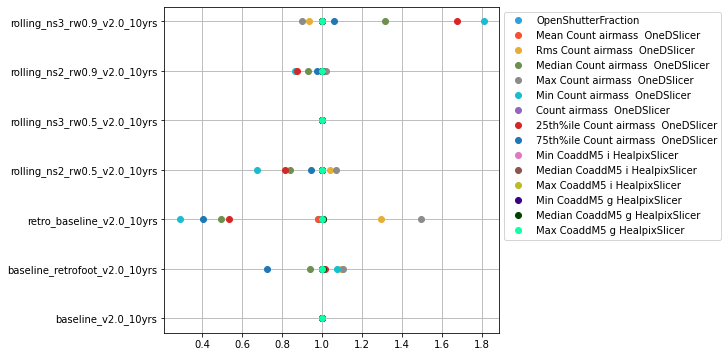

In [35]:
maf.plot_run_metric(
    baseline_run='baseline_v2.0_10yrs',
    summary=summary_matrix
)

The `baseline` argument normalized the various metrics against a baseline run, such that each metric has a value of 1.0 when it matches that of the baseline run, and if fractionall above or beneath 1.0 according to its fractional difference from the baseline value.

This approach is not appropriate for all metrics. For example, in some cases a higher metric value is better, while in others a lower one is better. In other cases, the metrics are in magnitudes, so fractional differences are not the most meaningful values to compare.

To change the manner in which metric values are normalized, a `pandas.DataFrame` can be created which supplies the plotting code with various bits of metadata about each metric:

In [36]:
# Make metrics default to linear scaling, bigger is better
metric_set = pd.DataFrame({'mag': False, 'invert': False, 'metric': summary_matrix.columns}).set_index('metric', drop=False)

# Smaller airmass is better, so invert airmass metrics
airmass_metrics = ['airmass' in m for m in metric_set.index]
metric_set.loc[airmass_metrics, 'invert'] = True

# CoaddM5 is a magnitude
mag_metrics = ['CoaddM5' in m for m in metric_set.index]
metric_set.loc[mag_metrics, 'mag'] = True

metric_set

,mag,invert,metric
metric,,,
OpenShutterFraction,False,False,OpenShutterFraction
Mean Count airmass OneDSlicer,False,True,Mean Count airmass OneDSlicer
Rms Count airmass OneDSlicer,False,True,Rms Count airmass OneDSlicer
Median Count airmass OneDSlicer,False,True,Median Count airmass OneDSlicer
Max Count airmass OneDSlicer,False,True,Max Count airmass OneDSlicer
Min Count airmass OneDSlicer,False,True,Min Count airmass OneDSlicer
N(+3Sigma) Count airmass OneDSlicer,False,True,N(+3Sigma) Count airmass OneDSlicer
N(-3Sigma) Count airmass OneDSlicer,False,True,N(-3Sigma) Count airmass OneDSlicer
Count airmass OneDSlicer,False,True,Count airmass OneDSlicer


(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

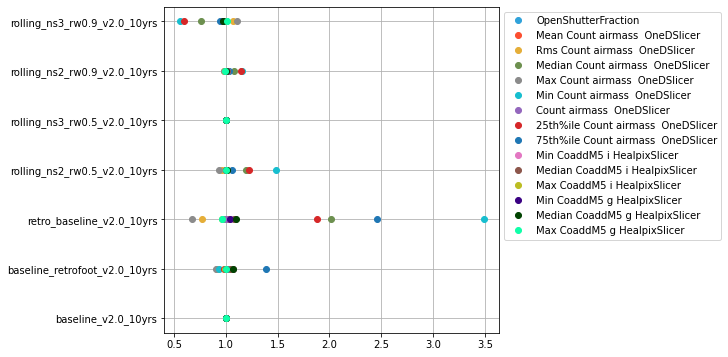

In [37]:
maf.plot_run_metric(
    baseline_run='baseline_v2.0_10yrs',
    summary=summary_matrix,
    metric_set=metric_set
)

If you want to compare many metrics on many runs, a mesh that gives all the values is useful:

(<Figure size 432x432 with 2 Axes>, <AxesSubplot:>)

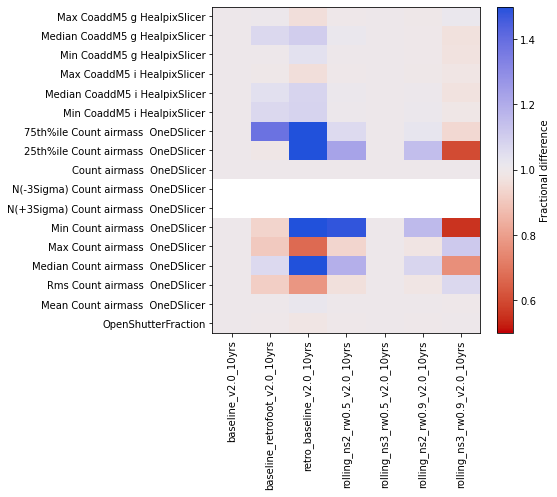

In [38]:
maf.plot_run_metric_mesh(
    baseline_run='baseline_v2.0_10yrs',
    summary=summary_matrix,
    metric_set=metric_set
)

You can further fiddle with the plot customization using arguments to the plotting functions and setting the style column in the `metric_set` `DataFrame`. For example, to see how depth in r and i vary with rolling stripes and strengths.

Begin by getting lists of metrics and runs we want to include in the plot:

In [39]:
rolling_test_runs = ['baseline_v2.0_10yrs'] + list(m for m in summary_matrix.index if 'rolling' in m)
depth_cols = list(m for m in summary_matrix.columns if 'CoaddM5' in m)

Set the plotting styles of each type of metric:

In [40]:
metric_set = pd.DataFrame({'mag': True, 'invert': False, 'metric': depth_cols}).set_index('metric', drop=False)
metric_set.loc[metric_set.metric.str.contains('g HealpixSlicer'), 'style'] = 'g'
metric_set.loc[metric_set.metric.str.contains('i HealpixSlicer'), 'style'] = 'r'

metric_set['style'] = metric_set['style'] + 'o'

min_idxs = metric_set.metric.str.contains('Min')
metric_set.loc[min_idxs, 'style'] = metric_set.loc[min_idxs, 'style'] + '--'
max_idxs = metric_set.metric.str.contains('Max')
metric_set.loc[max_idxs, 'style'] = metric_set.loc[max_idxs, 'style'] + ':'
median_idxs = metric_set.metric.str.contains('Median')
metric_set.loc[median_idxs, 'style'] = metric_set.loc[median_idxs, 'style'] + '-'

metric_set

,mag,invert,metric,style
metric,,,,
Min CoaddM5 i HealpixSlicer,True,False,Min CoaddM5 i HealpixSlicer,ro--
Median CoaddM5 i HealpixSlicer,True,False,Median CoaddM5 i HealpixSlicer,ro-
Max CoaddM5 i HealpixSlicer,True,False,Max CoaddM5 i HealpixSlicer,ro:
Min CoaddM5 g HealpixSlicer,True,False,Min CoaddM5 g HealpixSlicer,go--
Median CoaddM5 g HealpixSlicer,True,False,Median CoaddM5 g HealpixSlicer,go-
Max CoaddM5 g HealpixSlicer,True,False,Max CoaddM5 g HealpixSlicer,go:


Finally, actually make the plot:

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

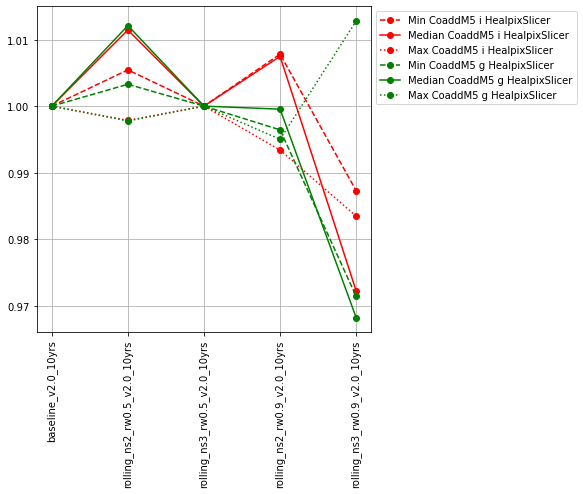

In [41]:
coadd_m5_cols = list(m for m in summary_matrix.columns if 'CoaddM5' in m)
maf.plot_run_metric(
    baseline_run='baseline_v2.0_10yrs',
    summary=summary_matrix.loc[rolling_test_runs, coadd_m5_cols],
    metric_set=metric_set,
    vertical_quantity='value',
    horizontal_quantity='run'
)

You can also make radar plots (but you must explicitly normalize the summary metrics):

(<Figure size 612x360 with 1 Axes>, <RadarAxesSubplot:>)

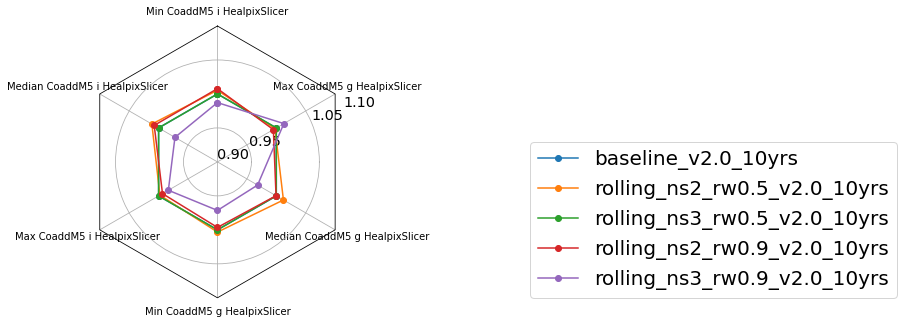

In [42]:
norm_sum_matrix = maf.normalize_metric_summaries('baseline_v2.0_10yrs', summary_matrix.loc[rolling_test_runs, coadd_m5_cols], metric_set)
maf.radar(norm_sum_matrix, rgrids=[0.9, 0.95, 1.05, 1.1], bbox_to_anchor=(3, 0))

# Summary data for v2.0 runs

The summary and data for a `metric_set` `DataFrame` are both available online as json files, and can be plotting with the plotting tools shown above.

Download the metric summary data itself thus:

In [43]:
summary_v2_url = 'https://raw.githubusercontent.com/lsst-pst/survey_strategy/main/fbs_2.0/summary_11_8.csv'

summary_v2 = pd.read_csv(summary_v2_url, index_col=0, low_memory=False)
summary_v2.index.name = "OpsimRun"
summary_v2

,fOArea fO All visits HealpixSlicer,fOArea/benchmark fO All visits HealpixSlicer,fONv MedianNvis fO All visits HealpixSlicer,fONv MinNvis fO All visits HealpixSlicer,fONv/benchmark MedianNvis fO All visits HealpixSlicer,fONv/benchmark MinNvis fO All visits HealpixSlicer,fOArea_750 fO All visits HealpixSlicer,Median Parallax Error (18k) Parallax Error @ 22.4 All visits HealpixSlicer,95th Percentile Parallax Error Parallax Error @ 22.4 All visits HealpixSlicer,Mean Parallax Error @ 22.4 All visits HealpixSlicer,...,Rms AGN SF_error z band HealpixSlicer,Median AGN SF_error z band HealpixSlicer,Max AGN SF_error z band HealpixSlicer,Min AGN SF_error z band HealpixSlicer,N(+3Sigma) AGN SF_error z band HealpixSlicer,N(-3Sigma) AGN SF_error z band HealpixSlicer,AGN SF_error z band HealpixSlicer,25th%ile AGN SF_error z band HealpixSlicer,75th%ile AGN SF_error z band HealpixSlicer,AreaThreshold AGN SF_error z band HealpixSlicer
OpsimRun,,,,,,,,,,,,,,,,,,,,,
baseline_nexp2_v1.7.1_10yrs,14469.422443,0.803857,846.0,781.0,1.025455,0.946667,18140.492848,2.324527,10.248834,4.894587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
baseline_retrofoot_v2.0_10yrs,17510.183320,0.972788,875.0,806.0,1.060606,0.976970,18175.743181,2.316875,9.982240,5.003306,...,0.028529,0.041893,0.375231,0.021676,510.0,0.0,28239.0,0.036523,0.058473,10157.970988
baseline_v2.0_10yrs,12893.228978,0.716290,839.0,787.0,1.016970,0.953939,18620.568813,2.423048,10.034633,4.640184,...,0.028729,0.042319,0.397783,0.020434,564.0,0.0,29529.0,0.037055,0.055711,9874.289736
bluer_indx0_v2.0_10yrs,12849.585708,0.713866,839.0,788.0,1.016970,0.955152,18610.497289,2.350626,10.182448,4.696561,...,0.028581,0.042704,0.324028,0.018749,606.0,0.0,29590.0,0.037204,0.056184,9416.035406
bluer_indx1_v2.0_10yrs,12876.443105,0.715358,839.0,788.0,1.016970,0.955152,18601.265059,2.362545,9.878032,4.456829,...,0.028097,0.042427,0.349829,0.018333,530.0,0.0,29542.0,0.037006,0.056446,9976.683561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vary_nes_nesfrac0.50_v2.0_10yrs,5425.194123,0.301400,811.0,761.0,0.983030,0.922424,18365.423545,2.437678,7.285735,4.043599,...,0.026420,0.042226,0.399182,0.019181,596.0,0.0,29521.0,0.036882,0.055094,10094.184671
vary_nes_nesfrac0.55_v2.0_10yrs,4007.627156,0.222646,804.0,753.0,0.974545,0.912727,18135.457086,2.451520,7.047335,3.856870,...,0.026370,0.042666,0.317128,0.018756,624.0,0.0,29612.0,0.037025,0.055315,9717.341824
vary_nes_nesfrac0.75_v2.0_10yrs,2155.306081,0.119739,777.0,722.0,0.941818,0.875152,14727.924886,2.453626,6.999647,3.967350,...,0.026070,0.042729,0.382272,0.018341,596.0,0.0,29543.0,0.037454,0.054829,9337.981097


In [44]:
metric_sets = pd.read_json('https://raw.githubusercontent.com/ehneilsen/survey_strategy/main/fbs_2.0/metric_sets.json', orient='records').set_index('metric', drop=False)
metric_sets

,metric set,metric,short_name,short_names_norm,style,invert,mag
metric,,,,,,,
fONv MedianNvis fO All visits HealpixSlicer,srd,fONv MedianNvis fO All visits HealpixSlicer,fONv MedianNvis,fONv MedianNvis,k-,False,False
Median Parallax Error (18k) Parallax Error @ 22.4 All visits HealpixSlicer,srd,Median Parallax Error (18k) Parallax Error @ 2...,Med Parallax Error @22.4,1 / Med Parallax Error @22.4,c-,True,False
Median Parallax Error (18k) Parallax Error @ 24.0 All visits HealpixSlicer,srd,Median Parallax Error (18k) Parallax Error @ 2...,Med Parallax Error @24.0,1 / Med Parallax Error @24.0,c:,True,False
Median Proper Motion Error (18k) Proper Motion Error @ 20.5 All visits HealpixSlicer,srd,Median Proper Motion Error (18k) Proper Motion...,Med PM Error @20.5,1 / Med PM Error @20.5,r-,True,False
Median Proper Motion Error (18k) Proper Motion Error @ 24.0 All visits HealpixSlicer,srd,Median Proper Motion Error (18k) Proper Motion...,Med PM Error @24.0,1 /Med PM Error @24.0,r:,True,False
...,...,...,...,...,...,...,...
FractionPop 6 of ugrizy MBA H=18.0,Fraction Pop 6 bands,FractionPop 6 of ugrizy MBA H=18.0,Fraction with ugrizy MBA H=18.0,Fraction with ugrizy MBA H=18.0,y--,False,False
FractionPop 6 of ugrizy Trojan H=14.0,Fraction Pop 6 bands,FractionPop 6 of ugrizy Trojan H=14.0,Fraction with ugrizy Trojan H=14.0,Fraction with ugrizy Trojan H=14.0,c-,False,False
FractionPop 6 of ugrizy Trojan H=15.0,Fraction Pop 6 bands,FractionPop 6 of ugrizy Trojan H=15.0,Fraction with ugrizy Trojan H=15.0,Fraction with ugrizy Trojan H=15.0,c--,False,False


In [45]:
these_runs = ['baseline_v2.0_10yrs'] + summary_v2.loc[summary_v2.index.str.startswith('rolling'), :].index.tolist()
these_runs

['baseline_v2.0_10yrs',
 'rolling_all_sky_ns2_rw0.9_v2.0_10yrs',
 'rolling_bulge_6_v2.0_10yrs',
 'rolling_bulge_ns2_rw0.5_v2.0_10yrs',
 'rolling_bulge_ns2_rw0.8_v2.0_10yrs',
 'rolling_bulge_ns2_rw0.9_v2.0_10yrs',
 'rolling_ns2_rw0.5_v2.0_10yrs',
 'rolling_ns2_rw0.9_v2.0_10yrs',
 'rolling_ns3_rw0.5_v2.0_10yrs',
 'rolling_ns3_rw0.9_v2.0_10yrs']

In [46]:
these_metrics = metric_sets.loc[metric_sets.index.str.match(r'Mean NVisits . band HealpixSlicer'), :].index.tolist()
these_metrics

['Mean NVisits u band HealpixSlicer',
 'Mean NVisits g band HealpixSlicer',
 'Mean NVisits r band HealpixSlicer',
 'Mean NVisits i band HealpixSlicer',
 'Mean NVisits z band HealpixSlicer',
 'Mean NVisits y band HealpixSlicer']

(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

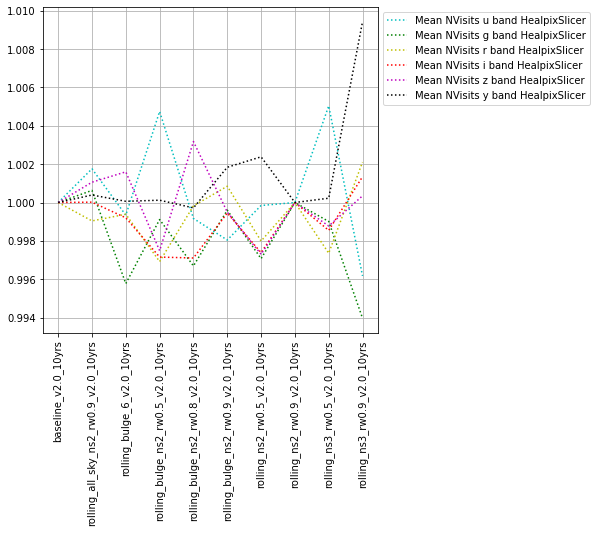

In [47]:
maf.plot_run_metric(
    baseline_run='baseline_v2.0_10yrs',
    summary=summary_v2.loc[these_runs, these_metrics],
    metric_set=metric_sets,
    vertical_quantity='value',
    horizontal_quantity='run'
)

(<Figure size 612x360 with 1 Axes>, <RadarAxesSubplot:>)

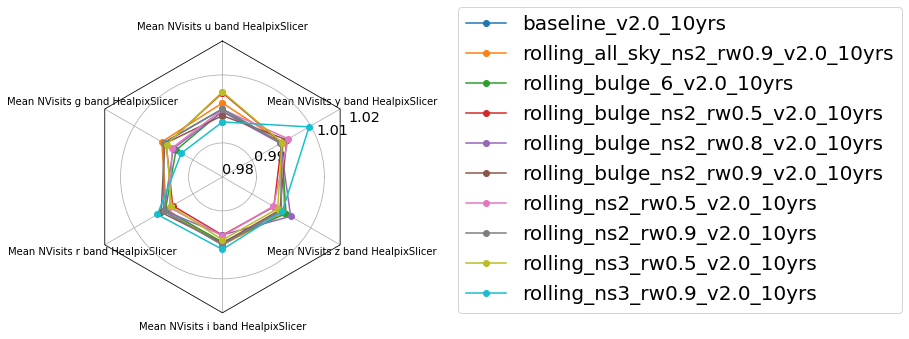

In [48]:
norm_sum_v2 = maf.normalize_metric_summaries('baseline_v2.0_10yrs', summary_v2.loc[these_runs, these_metrics], metric_sets)
maf.radar(norm_sum_v2, bbox_to_anchor=(3, 0), rgrids=[0.98, 0.99, 1.01, 1.02])